#  Analiza zmian jeziora Aralskiego (2017–2025)
## Sentinel‑2 + Microsoft Planetary Computer + Apache Sedona

**Cel ćwiczenia:**
1) Pobierz dane Sentinel‑2 (Green – `B03`, NIR – `B08`) z Microsoft Planetary Computer dla jeziora Aralskiego — po 1 scenie na każdy rok 2017–2025 (preferencyjnie czerwiec–sierpień, zachmurzenie < 10%).
2) Wczytaj dane do Apache Sedona (Spark) i wykonaj analizę NDWI: `NDWI = (Green - NIR) / (Green + NIR)`.
3) Zwizualizuj zmiany średniego NDWI w czasie.



##  Środowisko i biblioteki
Zalecane biblioteki:
- `pystac-client`, `planetary_computer`, 

Zainstaluj, jeśli potrzeba (np. dla obrazu Dockera)

In [1]:
!pip install pystac-client
!pip install planetary-computer
!pip install rioxarray


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


## 1) Pobranie danych z Microsoft Planetary Computer
Napisz funkcję `get_aral_s2(years, bbox)`, która dla każdego roku zwróci po 1 najlepszej scenie Sentinel‑2 L2A (najmniejsze zachmurzenie w czerwcu–sierpniu).

**Wskazówki:**
- Katalog STAC: `https://planetarycomputer.microsoft.com/api/stac/v1`
- Kolekcja: `sentinel-2-l2a`
- Filtrowanie: `datetime`, `bbox`, `eo:cloud_cover < 20`, preferuj letnie miesiące.
- Użyj `planetary_computer.sign()` do podpisywania assets.
- Do wczytania pasm użyj `stackstac.stack()`.

In [2]:
from pystac_client import Client
import planetary_computer
import os
import requests

In [3]:
def get_aral_s2_mgrs(start_year, end_year, mgrs_tile, output_dir):
    """
    Downloads the best Sentinel-2 L2A scene for each year (lowest cloud cover, June–August)
    for the given MGRS tile and saves B03 and B08 bands as GeoTIFF files.

    Parameters:
    ----------
    start_year : int
        Start year (e.g. 2017)
    end_year : int
        End year (e.g. 2025)
    mgrs_tile : str
        MGRS tile ID (e.g. '40TGS')
    output_dir : str
        Path to the directory where .tif files will be saved

    Returns:
    ------
    None (files are saved locally in output_dir)
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Connect to Planetary Computer STAC
    stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # Loop over years
    for year in range(start_year, end_year + 1):
        start = f"{year}-06-01"
        end = f"{year}-08-31"
        print(f"\nSearching for best Sentinel-2 L2A scene for {mgrs_tile}, year {year} ({start} → {end})")

        # Search for scenes in the given tile and date range
        search = stac.search(
            collections=["sentinel-2-l2a"],
            query={
                "s2:mgrs_tile": {"eq": mgrs_tile},
                "eo:cloud_cover": {"lt": 40}
            },
            datetime=f"{start}/{end}",
            sortby=[{"field": "properties.eo:cloud_cover", "direction": "asc"}],
            limit=1
        )

        items = list(search.items())
        if not items:
            print(f"No scenes found for year {year}.")
            continue

        item = items[0]
        date = item.properties["datetime"]
        cloud = item.properties.get("eo:cloud_cover", "?")
        print(f"Selected scene: {item.id} ({date}, cloud cover: {cloud}%)")

        # Download B03 and B08 bands
        for band in ["B03", "B08"]:
            asset = item.assets.get(band)
            if not asset:
                print(f"Band {band} not found in {item.id}")
                continue

            signed_href = planetary_computer.sign(asset.href)
            out_path = os.path.join(output_dir, f"{year}_{band}_{mgrs_tile}.tif")

            # Skip if file already exists
            if os.path.exists(out_path):
                print(f"Already exists: {out_path}")
                continue

            # Download file
            print(f"Downloading {band} → {out_path}")
            with requests.get(signed_href, stream=True) as r:
                r.raise_for_status()
                with open(out_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=1024 * 1024):
                        f.write(chunk)

            print(f"Saved: {out_path}")

    print("\nFinished downloading all years.")


In [ ]:
!mkdir /opt/workspace/lab1_data

In [7]:
!pwd mkdir lab1_data

/opt/workspace


In [4]:
# Przykładowe wywołanie funkcji get_aral_s2

get_aral_s2_mgrs(
    start_year=2017,
    end_year=2025,
    mgrs_tile="40TFR",
    output_dir="/opt/workspace/lab1_data"
)


Searching for best Sentinel-2 L2A scene for 40TFR, year 2017 (2017-06-01 → 2017-08-31)
Selected scene: S2B_MSIL2A_20170803T071309_R106_T40TFR_20210210T185818 (2017-08-03T07:13:09.027000Z, cloud cover: 12.814492%)
Selected scene: S2B_MSIL2A_20170803T071309_R106_T40TFR_20210210T185818 (2017-08-03T07:13:09.027000Z, cloud cover: 12.814492%)
Saved: /opt/workspace/lab1_data/2017_B03_40TFR.tif
Saved: /opt/workspace/lab1_data/2017_B03_40TFR.tif
Saved: /opt/workspace/lab1_data/2017_B08_40TFR.tif

Searching for best Sentinel-2 L2A scene for 40TFR, year 2018 (2018-06-01 → 2018-08-31)
Saved: /opt/workspace/lab1_data/2017_B08_40TFR.tif

Searching for best Sentinel-2 L2A scene for 40TFR, year 2018 (2018-06-01 → 2018-08-31)
Selected scene: S2B_MSIL2A_20180719T070619_R106_T40TFR_20201011T173925 (2018-07-19T07:06:19.024000Z, cloud cover: 19.837937%)
Selected scene: S2B_MSIL2A_20180719T070619_R106_T40TFR_20201011T173925 (2018-07-19T07:06:19.024000Z, cloud cover: 19.837937%)
Saved: /opt/workspace/lab1_d

## 2) Wczytanie do Apache Sedona i przygotowanie danych NDWI
Utwórz sesję Spark + Sedona. Następnie załaduj raster

In [5]:
from sedona.spark import SedonaContext
config = (
    SedonaContext.builder()
    .config(
        "spark.jars.packages",
        ",".join([
            "org.apache.sedona:sedona-spark-shaded-4.0_2.13:1.8.0",
            "org.datasyslab:geotools-wrapper:1.8.0-33.1",
            "org.apache.hadoop:hadoop-aws:3.3.2"
        ])
    )
    .config("spark.jars.repositories", "https://artifacts.unidata.ucar.edu/repository/unidata-all")        
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "true") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", 
        "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
    .config("spark.executor.memory", "6G")
    .config("spark.driver.memory", "6G")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)
 
sedona = SedonaContext.create(config)
sedona.sparkContext.setLogLevel("ERROR")
 
sedona.conf.set("fs.https.impl", "org.apache.hadoop.fs.http.HttpsFileSystem")

https://artifacts.unidata.ucar.edu/repository/unidata-all added as a remote repository with the name: repo-1
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.sedona#sedona-spark-shaded-4.0_2.13 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ae0a3ae5-7fc2-467e-8851-256b7cad3afb;1.0
	confs: [default]


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.sedona#sedona-spark-shaded-4.0_2.13;1.8.0 in central
	found org.datasyslab#geotools-wrapper;1.8.0-33.1 in central
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.1026 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 291ms :: artifacts dl 8ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.1026 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.2 from central in [default]
	org.apache.sedona#sedona-spark-shaded-4.0_2.13;1.8.0 from central in [default]
	org.datasyslab#geotools-wrapper;1.8.0-33.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	-------------------------------------

In [6]:
import os
import numpy as np
import rasterio
from pyspark.sql import Row

## 3) Obliczenie NDWI
Uzyj wzoru `ndwi = (green - nir) / (green + nir)` i policz średni NDWI dla każdego roku.

In [7]:
input_dir = "/opt/workspace/lab1_data"
mgrs_tile = "40TFR"

output_dir = os.path.join(input_dir, "sentinel_ndwi")
os.makedirs(output_dir, exist_ok=True)

# Find B03 and B08 files
b03_files = sorted([f for f in os.listdir(input_dir) if "_B03_" in f])
b08_files = sorted([f for f in os.listdir(input_dir) if "_B08_" in f])

# Match pairs (B03 ↔ B08) by year
pairs = []
for b03 in b03_files:
    year = b03.split("_")[0]
    match = [f for f in b08_files if year in f]
    if match:
        pairs.append((year, os.path.join(input_dir, b03), os.path.join(input_dir, match[0])))

print(f"Found {len(pairs)} file pairs to process.")

# Function to calculate NDWI and save raster
def compute_ndwi(year, b03_path, b08_path):
    try:
        with rasterio.open(b03_path) as b3, rasterio.open(b08_path) as b8:
            green = b3.read(1).astype("float32")
            nir = b8.read(1).astype("float32")

            # NDWI = (Green - NIR) / (Green + NIR)
            ndwi = np.where((green + nir) != 0, (green - nir) / (green + nir), 0)

            profile = b3.profile
            profile.update(dtype=rasterio.float32, count=1, compress='lzw')

            out_path = os.path.join(output_dir, f"{year}_NDWI.tif")
            with rasterio.open(out_path, "w", **profile) as dst:
                dst.write(ndwi, 1)

        return Row(year=int(year), path=out_path)

    except Exception as e:
        print(f"Error processing {year}: {e}")
        return Row(year=int(year), path=None)

# Sequential processing
results = []
for p in pairs:
    results.append(compute_ndwi(*p))

print("\nSaved NDWI files:")
for r in results:
    if r.path:
        print(f"   {r.year} → {r.path}")


Found 18 file pairs to process.


/tmp/ipykernel_2224/2424384469.py:29: RuntimeWarning: invalid value encountered in divide
  ndwi = np.where((green + nir) != 0, (green - nir) / (green + nir), 0)



Saved NDWI files:
   2017 → /opt/workspace/lab1_data/sentinel_ndwi/2017_NDWI.tif
   2017 → /opt/workspace/lab1_data/sentinel_ndwi/2017_NDWI.tif
   2018 → /opt/workspace/lab1_data/sentinel_ndwi/2018_NDWI.tif
   2018 → /opt/workspace/lab1_data/sentinel_ndwi/2018_NDWI.tif
   2019 → /opt/workspace/lab1_data/sentinel_ndwi/2019_NDWI.tif
   2019 → /opt/workspace/lab1_data/sentinel_ndwi/2019_NDWI.tif
   2020 → /opt/workspace/lab1_data/sentinel_ndwi/2020_NDWI.tif
   2020 → /opt/workspace/lab1_data/sentinel_ndwi/2020_NDWI.tif
   2021 → /opt/workspace/lab1_data/sentinel_ndwi/2021_NDWI.tif
   2021 → /opt/workspace/lab1_data/sentinel_ndwi/2021_NDWI.tif
   2022 → /opt/workspace/lab1_data/sentinel_ndwi/2022_NDWI.tif
   2022 → /opt/workspace/lab1_data/sentinel_ndwi/2022_NDWI.tif
   2023 → /opt/workspace/lab1_data/sentinel_ndwi/2023_NDWI.tif
   2023 → /opt/workspace/lab1_data/sentinel_ndwi/2023_NDWI.tif
   2024 → /opt/workspace/lab1_data/sentinel_ndwi/2024_NDWI.tif
   2024 → /opt/workspace/lab1_data/s

## 4) Wykres zmian NDWI (2017–2025)
Utwórz wykres liniowy średniego NDWI.

In [8]:
import glob
import numpy as np
import rasterio

In [9]:
ndwi_means = {}
for path in glob.glob(os.path.join(output_dir, "*_NDWI.tif")):
    year = int(os.path.basename(path).split("_")[0])
    with rasterio.open(path) as src:
        arr = src.read(1)
        ndwi_means[year] = float(np.nanmean(arr))

print("\nMean NDWI for each year:")
for y, val in sorted(ndwi_means.items()):
    print(f"{y}: {val:.4f}")


Mean NDWI for each year:
2017: 0.3811
2018: -0.5330
2019: 0.3701
2020: -0.5309
2021: -1.0000
2022: -0.1433
2023: -0.1220
2024: -0.6997
2025: -0.1081


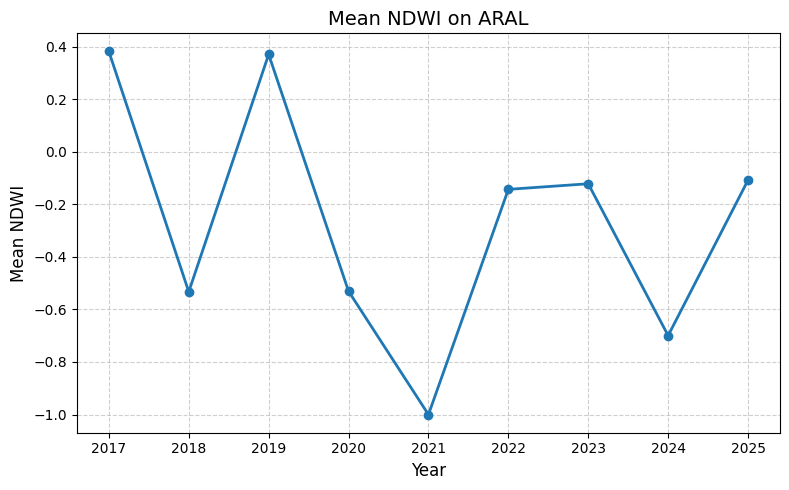

In [10]:
import matplotlib.pyplot as plt
years = sorted(ndwi_means.keys())
values = [ndwi_means[y] for y in years]

plt.figure(figsize=(8, 5))
plt.plot(years, values, marker='o', linestyle='-', linewidth=2)

plt.title("Mean NDWI on ARAL", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mean NDWI", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

## 5) Wizualizacja wyników - wszystkie lata


In [11]:
import os
import glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt

**unable to plot result. Kernel crashes probably due to the limited RAM for docker (unable to increase)**

In [12]:
output_dir = "/opt/workspace/lab1_data/sentinel_ndwi"

ndwi_files = sorted([f for f in os.listdir(output_dir) if f.endswith("_NDWI.tif")])


cols = 3
rows = int(np.ceil(len(ndwi_files) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for i, f in enumerate(ndwi_files):
    path = os.path.join(output_dir, f)
    year = f.split("_")[0]
    with rasterio.open(path) as src:
        ndwi = src.read(1, masked=True)
        img = axes[i].imshow(ndwi, cmap="BrBG", vmin=-1, vmax=1)
        axes[i].set_title(year)
        axes[i].axis("off")


fig.colorbar(img, ax=axes, orientation="horizontal", fraction=0.03, pad=0.05, label="NDWI")
plt.suptitle("NDWI Aral- 2017-2025", fontsize=14)
plt.tight_layout()
plt.show()

: 

: 

: 